In [1]:
import pandas as pd
import json
from os import path
import numpy as np
import matplotlib.pyplot as plt

# Modeling
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
import pmdarima as pm # autoarima
from sktime.forecasting.ltsf import LTSFLinearForecaster,LTSFDLinearForecaster,LTSFNLinearForecaster

In [2]:
def ts_split(train_df,test_pct = 0.2,random_state = 25,freq = 'D'):
    from sklearn.model_selection import train_test_split
    train_df = train_df.groupby(pd.Grouper(freq=freq)).mean(numeric_only = True)
    test_size = int(len(train_df)*test_pct)
    train_data, test_data = train_test_split(train_df, test_size=test_size, random_state=random_state, shuffle = False)
    return train_data,test_data

# Function to calculate Errors
def errors(truth = np.array([[1,1]]),pred = np.array([[1,1]])):
    from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

    error_str = "\n\
    Mean Squared Error: {:0.3f}\n\
    Mean Absolute Error: {:0.3f}\n\
    Mean Absolute Percentage Error: {:0.3f}\n\
    Weighted Mean Squared Error: {:0.3f}\n\
    Mean Forecast Error: {:0.3f}\n\
    ".format(mean_squared_error(truth,pred)**0.5,
    mean_absolute_error(truth,pred),
    mean_absolute_percentage_error(truth,pred),
    mean_squared_error(truth,pred,sample_weight=np.exp(-np.arange(len(truth))))**0.5,
    np.mean(truth-pred))
    return error_str

def get_error(truth,pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
    return mean_squared_error(truth,pred)**0.5

def check_error(cur_error,min_error):
    if cur_error < min_error:
        return True
    else:
        return False


In [3]:
def ets_models(train_data,test_data,col_name,pts_to_pred):
    min_error = np.inf
    best_model = None

    granularity = 0.01
    for level in np.arange(0, 1 + granularity, granularity):
        ses = SimpleExpSmoothing(train_data[col_name]).fit(smoothing_level=level,optimized=False)
        ses_forecast = ses.forecast(pts_to_pred)
        cur_error  = get_error(test_data[col_name],ses_forecast.values)
        if check_error(cur_error,min_error):
            min_error = cur_error
            best_model = ses
    
    for type in ["add","mul"]:
        des = ExponentialSmoothing(train_data[col_name], trend=type).fit()
        des_forecast = des.forecast(pts_to_pred)
        cur_error  = get_error(test_data[col_name],des_forecast.values)
        if check_error(cur_error,min_error):
            min_error = cur_error
            best_model = des

    for comb in [("add","add"),("add","mul"),("mul","add"),("mul","mul")]:
        for seasonality in range(2,13):
            tes = ExponentialSmoothing(train_data[col_name],trend=comb[0],seasonal=comb[1],seasonal_periods=seasonality).fit()
            tes_forecast = tes.forecast(pts_to_pred)
            cur_error  = get_error(test_data[col_name],tes_forecast.values)
            if check_error(cur_error,min_error):
                min_error = cur_error
                best_model = tes
    return best_model
        
def arima_models(train_data,test_data,col_name,pts_to_pred):
    best_model = None
    min_error = np.inf
    # Check ARIMA max_p,max_q,stepwise
    for seasonality in range(1,13):
        model = pm.auto_arima(train_data[col_name],
                            test='adf',
                            max_p=2, max_q=2, m=seasonality,
                            seasonal=True,
                            trace=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
        model_forecast = model.predict(n_periods=pts_to_pred, return_conf_int=False)
        cur_error = get_error(test_data[col_name],model_forecast)
        if check_error(cur_error,min_error):
                min_error = cur_error
                best_model = model
    return best_model

def ltsf_models(train_data,test_data,col_name,pts_to_pred):
    # Documentation: https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.ltsf.LTSFLinearForecaster.html#ltsflinearforecaster
    best_model = None
    min_error = np.inf

    for model in [LTSFLinearForecaster,LTSFDLinearForecaster,LTSFNLinearForecaster]:
        for ip_seq_len in [4,52,10,8,5]:
            for batch_size in [4,8,16,32]:
                for epochs in range(10,101,10):
                    cur_model = model(ip_seq_len,len(test_data),num_epochs=epochs,batch_size=batch_size) 
                    cur_model.fit(train_data[col_name], fh=list(range(len(test_data))))
                    model_forecast = cur_model.predict() 
                    cur_error = get_error(test_data[col_name],model_forecast)
                    if check_error(cur_error,min_error):
                            min_error = cur_error
                            best_model = cur_model
    
    return best_model


def pretraining_plot(train_df,test_df,col_name,title = "Title"):
    plt.figure(figsize=(10, 5))
    train_df[col_name].plot(label='Train')
    test_df[col_name].plot(label='Test')
    plt.title(title)
    plt.xlabel('Date')
    plt.legend()


def posttraining_plot(train_df,test_df,col_name,best_model,title = "Title"):
    plt.figure(figsize=(10, 5))
    train_df[col_name].plot(label='Train',color= "black")
    test_df[col_name].plot(label='Test',color = "orange")
    best_forecast = best_model.forecast(len(test_df))
    print(errors(test_df[col_name],best_forecast))
    pd.Series(best_forecast,index=test_df.index).plot(label="Best Model Pred",color = "blue")
    plt.title(title)
    plt.xlabel('Date')
    plt.legend()


In [4]:
class BestModelWrapper:
    def __init__(self, model):
        self.best_model = model
        self.model_type = str(type(model))
        self._forecast_call = self._get_forecast_call()

    def forecast(self,pts_to_pred):
        cur_forecast = None
        if self._forecast_call == 0:
            cur_forecast = self.best_model.predict(n_periods=pts_to_pred, return_conf_int=False)
        elif self._forecast_call == 1:
            cur_forecast = self.best_model.predict()
        else:
            cur_forecast = self.best_model.forecast(pts_to_pred).values
        return cur_forecast
    
    def _get_forecast_call(self):
        if self.model_type == "<class 'pmdarima.arima.arima.ARIMA'>":
            return 0
        elif self.model_type in ["<class 'sktime.forecasting.ltsf.LTSFDLinearForecaster'>","<class 'sktime.forecasting.ltsf.LTSFLinearForecaster'>","<class 'sktime.forecasting.ltsf.LTSFNLinearForecaster'>"]:
            return 1
        else:
            return 2

In [5]:
trainf_path = "/Users/atharvamhaskar/Documents/CMU_95835_Time_Series_Forecasting/code/project/predict-energy-behavior-of-prosumers" # - Directory with train csv files.  
testf_path = "/Users/atharvamhaskar/Documents/CMU_95835_Time_Series_Forecasting/code/project/predict-energy-behavior-of-prosumers/example_test_files" # - Directory with test csv files.

# trainf_path =  # - Directory with train csv files.  
# testf_path =  # - Directory with test csv files.

client_csv = "client.csv"
electricity_prices_csv = "electricity_prices.csv"
train_csv = "train.csv"

In [6]:
client_df = pd.read_csv(path.join(trainf_path,client_csv))
electricity_prices_df = pd.read_csv(path.join(trainf_path,electricity_prices_csv))
train_df = pd.read_csv(path.join(trainf_path,train_csv))


In [7]:
# client.csv

# product_type
# county - An ID code for the county. See county_id_to_name_map.json for the mapping of ID codes to county names.
# eic_count - The aggregated number of consumption points (EICs - European Identifier Code).
# installed_capacity - Installed photovoltaic solar panel capacity in kilowatts.
# is_business - Boolean for whether or not the prosumer is a business.
# date
# data_block_id
client_df.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [8]:
# electricity_prices.csv

# origin_date
# forecast_date
# euros_per_mwh - The price of electricity on the day ahead markets in euros per megawatt hour.
# data_block_id
electricity_prices_df.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [9]:
# county - An ID code for the county.
# is_business - Boolean for whether or not the prosumer is a business.
# product_type - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
# target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
# is_consumption - Boolean for whether or not this row's target is consumption or production.
# datetime - The Estonian time in EET (UTC+2) / EEST (UTC+3).
# data_block_id - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
# row_id - A unique identifier for the row.
# prediction_unit_id - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.
train_df["county"].value_counts()

0     212928
11    198000
7     173088
5     151632
15    148752
4     147264
10    134640
14    125808
3     122496
9     122496
13    121056
2     115200
1      91872
8      91872
6      30624
12     30624
Name: county, dtype: int64

In [10]:
print(train_df.county.unique())
select_county = 5

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


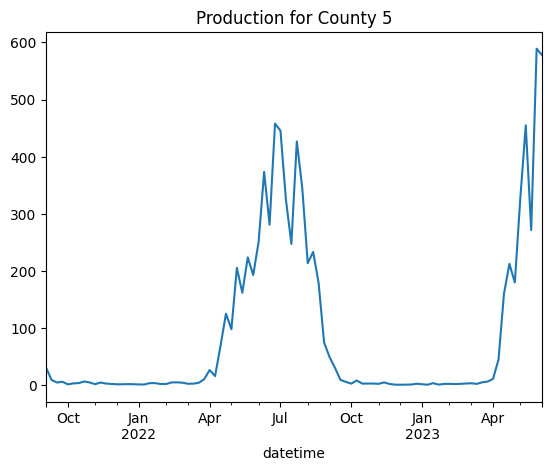

In [11]:
temp = train_df.copy()
temp = temp[temp["is_consumption"] == 0]
temp.set_index("datetime",inplace=True)
filtered_temp = temp.groupby(by = [temp.index,"county"]).sum()
filtered_temp.reset_index(inplace=True)
filtered_temp = filtered_temp[filtered_temp["county"] == select_county]
filtered_temp["datetime"] = pd.to_datetime(filtered_temp["datetime"])
filtered_temp.set_index("datetime",inplace=True)
filtered_temp = filtered_temp.groupby(pd.Grouper(freq='W')).median()
filtered_temp["target"].plot()
plt.title("Production for County {}".format(select_county))
plt.show()

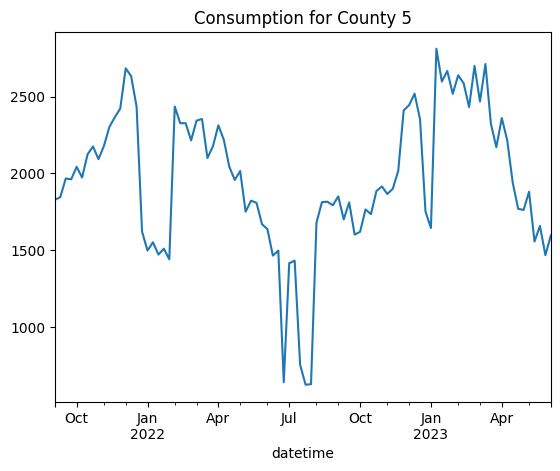

In [12]:
temp = train_df.copy()
temp = temp[temp["is_consumption"] == 1]
temp.set_index("datetime",inplace=True)
filtered_temp = temp.groupby(by = [temp.index,"county"]).sum()
filtered_temp.reset_index(inplace=True)
filtered_temp = filtered_temp[filtered_temp["county"] == select_county]
filtered_temp["datetime"] = pd.to_datetime(filtered_temp["datetime"])
filtered_temp.set_index("datetime",inplace=True)
filtered_temp = filtered_temp.groupby(pd.Grouper(freq='W')).median()
filtered_temp["target"].plot()
plt.title("Consumption for County {}".format(select_county))
plt.show()

<AxesSubplot: xlabel='origin_date'>

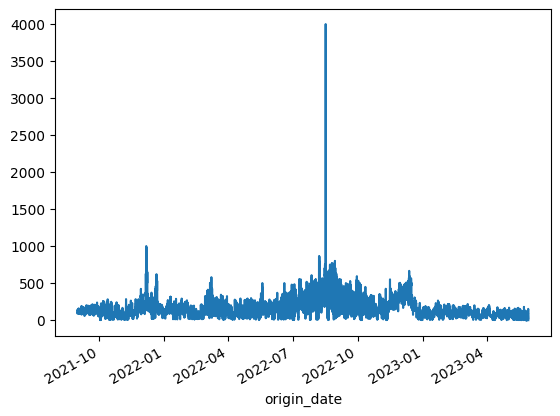

In [13]:
electricity_prices_df
electricity_prices_df["forecast_date"] = pd.to_datetime(electricity_prices_df["forecast_date"])
electricity_prices_df["origin_date"] = pd.to_datetime(electricity_prices_df["origin_date"]) 
electricity_prices_df.set_index("origin_date",inplace=True)

electricity_prices_df["euros_per_mwh"].plot()

In [14]:
def ts_split(train_df,test_pct = 0.2,random_state = 25,freq = 'D'):
    from sklearn.model_selection import train_test_split
    train_df = train_df.groupby(pd.Grouper(freq=freq)).mean(numeric_only = True)
    test_size = int(len(train_df)*test_pct)
    train_data, test_data = train_test_split(train_df, test_size=test_size, random_state=random_state, shuffle = False)
    return train_data,test_data

# Function to calculate Errors
def errors(truth = np.array([[1,1]]),pred = np.array([[1,1]])):
    from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

    error_str = "\n\
    Mean Squared Error: {:0.3f}\n\
    Mean Absolute Error: {:0.3f}\n\
    Mean Absolute Percentage Error: {:0.3f}\n\
    Weighted Mean Squared Error: {:0.3f}\n\
    Mean Forecast Error: {:0.3f}\n\
    ".format(mean_squared_error(truth,pred)**0.5,
    mean_absolute_error(truth,pred),
    mean_absolute_percentage_error(truth,pred),
    mean_squared_error(truth,pred,sample_weight=np.exp(-np.arange(len(truth)))),
    np.mean(truth-pred))
    return error_str

### Model to predict electricity price

In [15]:
train_data,test_data = ts_split(electricity_prices_df,test_pct=0.2,freq = 'W')
pts_to_pred = len(test_data)

# Simple Exponential Smoothing - No trend No seasonality
ses = SimpleExpSmoothing(train_data["euros_per_mwh"]).fit(smoothing_level=0.7,optimized=False)
ses_forecast = ses.forecast(pts_to_pred)

# Double Exponential Smoothing / Holts Exponential Smoothing - Trend but No seasonality
des = ExponentialSmoothing(train_data["euros_per_mwh"], trend="mul").fit()
des_forecast = des.forecast(pts_to_pred)

# Triple Exponential Smoothing - Winters Exponential Smoothing - Trend and Seasonality
tes = ExponentialSmoothing(train_data["euros_per_mwh"],trend="mul",seasonal="add",seasonal_periods=10).fit()
tes_forecast = tes.forecast(pts_to_pred)

/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


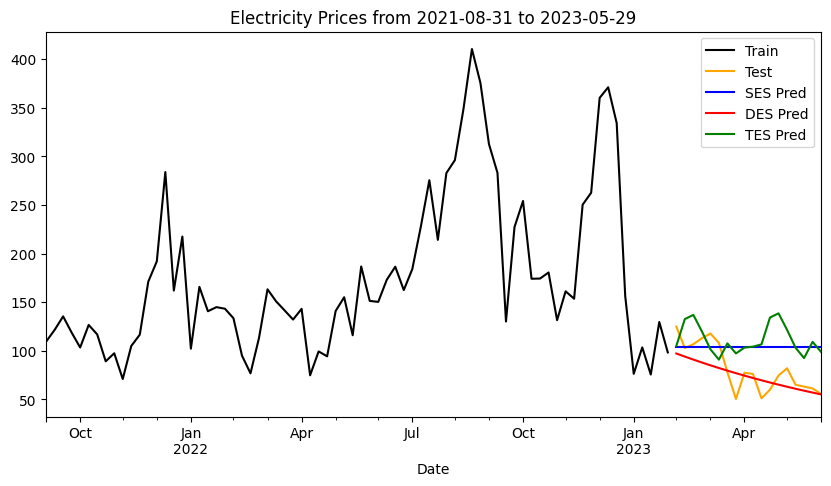

In [16]:
plt.figure(figsize=(10, 5))

# TRAIN
train_data['euros_per_mwh'].plot(label='Train',color= "black")
# TEST
test_data['euros_per_mwh'].plot(label='Test',color = "orange")

# SES
# ses.fittedvalues.plot(label = "SES Train",color="blue")
ses_forecast.plot(label="SES Pred",color = "blue")

# DES / HES
# des.fittedvalues.plot(label = "DES Train",color="yellow")
des_forecast.plot(label="DES Pred",color = "red")

# TES / WES
# tes.fittedvalues.plot(label = "TES Train",color="green")
tes_forecast.plot(label="TES Pred",color = "green")


plt.title('Electricity Prices from {} to {}'.format(str(electricity_prices_df.index[0]).split()[0], str(electricity_prices_df.index[-1]).split()[0]))
plt.xlabel('Date')
plt.legend()

In [17]:
error_ses = test_data.values - ses_forecast.values.reshape(pts_to_pred,1)
error_des = test_data.values - des_forecast.values.reshape(pts_to_pred,1)
error_tes = test_data.values - tes_forecast.values.reshape(pts_to_pred,1)

In [18]:
print("Error Values for SES Model is:")
print(errors(test_data["euros_per_mwh"],ses_forecast.values))

print("\nError Values for DES Model is:")
print(errors(test_data["euros_per_mwh"],des_forecast.values))

print("\nError Values for TES Model is:")
print(errors(test_data["euros_per_mwh"],tes_forecast.values))

Error Values for SES Model is:

    Mean Squared Error: 32.462
    Mean Absolute Error: 27.923
    Mean Absolute Percentage Error: 0.431
    Weighted Mean Squared Error: 293.145
    Mean Forecast Error: -22.147
    

Error Values for DES Model is:

    Mean Squared Error: 16.817
    Mean Absolute Error: 13.255
    Mean Absolute Percentage Error: 0.160
    Weighted Mean Squared Error: 559.505
    Mean Forecast Error: 7.227
    

Error Values for TES Model is:

    Mean Squared Error: 39.491
    Mean Absolute Error: 35.713
    Mean Absolute Percentage Error: 0.521
    Weighted Mean Squared Error: 542.583
    Mean Forecast Error: -29.791
    


### Models to predict consumption

No. of training examples: 74
No. of testing examples: 18


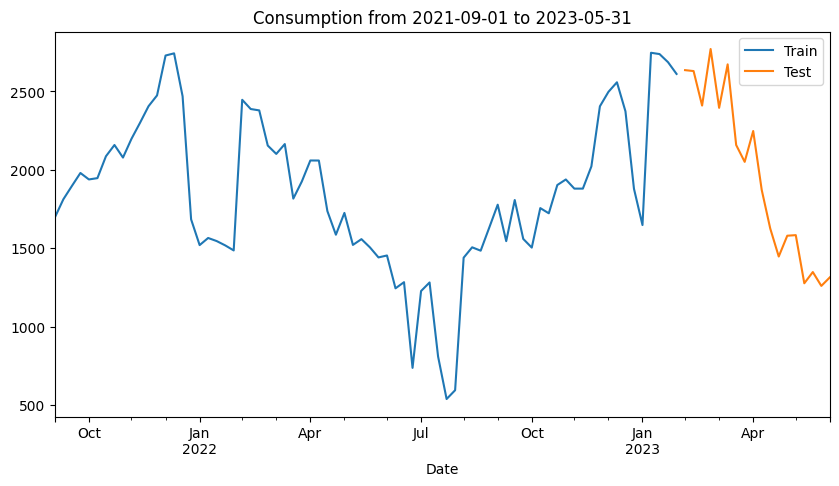

In [19]:
select_county = 5

temp = train_df.copy()
temp["datetime"] = pd.to_datetime(temp["datetime"])
consumption_df = temp[temp["is_consumption"] == 1]
consumption_df.set_index("datetime",inplace=True)
consumption_df = consumption_df.groupby(by = [consumption_df.index,"county"]).sum()
consumption_df.reset_index(inplace=True)
consumption_df.set_index("datetime",inplace=True)
consumption_df = consumption_df[consumption_df["county"] == select_county]

consumption_df.head()


train_data, test_data = ts_split(consumption_df,test_pct=0.2,freq='W')
pts_to_pred = len(test_data)

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")


plt.figure(figsize=(10, 5))
train_data['target'].plot(label='Train')
test_data['target'].plot(label='Test')
plt.title('Consumption from {} to {}'.format(str(consumption_df.index[0]).split()[0], str(consumption_df.index[-1]).split()[0]))
plt.xlabel('Date')
plt.legend()

In [20]:
# Simple Exponential Smoothing - No trend No seasonality
ses = SimpleExpSmoothing(train_data["target"]).fit(smoothing_level=0.7,optimized=False)
ses_forecast = ses.forecast(pts_to_pred)

# Double Exponential Smoothing / Holts Exponential Smoothing - Trend but No seasonality
des = ExponentialSmoothing(train_data["target"], trend="mul").fit()
des_forecast = des.forecast(pts_to_pred)

# Triple Exponential Smoothing - Winters Exponential Smoothing - Trend and Seasonality
tes = ExponentialSmoothing(train_data["target"],trend="mul",seasonal="add",seasonal_periods=12).fit()
tes_forecast = tes.forecast(pts_to_pred)

/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


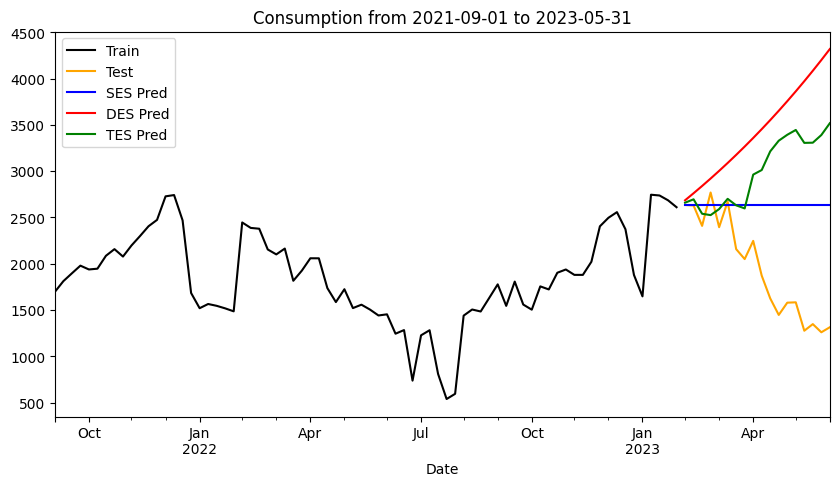

In [21]:
plt.figure(figsize=(10, 5))

# TRAIN
train_data['target'].plot(label='Train',color= "black")
# TEST
test_data['target'].plot(label='Test',color = "orange")

# SES
# ses.fittedvalues.plot(label = "SES Train",color="blue")
ses_forecast.plot(label="SES Pred",color = "blue")

# DES / HES
# des.fittedvalues.plot(label = "DES Train",color="yellow")
des_forecast.plot(label="DES Pred",color = "red")

# TES / WES
# tes.fittedvalues.plot(label = "TES Train",color="green")
tes_forecast.plot(label="TES Pred",color = "green")


plt.title('Consumption from {} to {}'.format(str(consumption_df.index[0]).split()[0], str(consumption_df.index[-1]).split()[0]))
plt.xlabel('Date')
plt.legend()

In [22]:
error_ses = test_data.values - ses_forecast.values.reshape(pts_to_pred,1)
error_des = test_data.values - des_forecast.values.reshape(pts_to_pred,1)
error_tes = test_data.values - tes_forecast.values.reshape(pts_to_pred,1)

In [23]:
print("Error Values for SES Model is:")
print(errors(test_data["target"],ses_forecast.values))

print("\nError Values for DES Model is:")
print(errors(test_data["target"],des_forecast.values))

print("\nError Values for TES Model is:")
print(errors(test_data["target"],tes_forecast.values))

Error Values for SES Model is:

    Mean Squared Error: 853.383
    Mean Absolute Error: 691.540
    Mean Absolute Percentage Error: 0.456
    Weighted Mean Squared Error: 6129.447
    Mean Forecast Error: -670.895
    

Error Values for DES Model is:

    Mean Squared Error: 1795.052
    Mean Absolute Error: 1482.834
    Mean Absolute Percentage Error: 0.968
    Weighted Mean Squared Error: 30476.838
    Mean Forecast Error: -1482.834
    

Error Values for TES Model is:

    Mean Squared Error: 1346.899
    Mean Absolute Error: 1058.027
    Mean Absolute Percentage Error: 0.706
    Weighted Mean Squared Error: 6085.492
    Mean Forecast Error: -1030.877
    


### Models to predict production

In [24]:
select_county = 1

temp = train_df.copy()
temp["datetime"] = pd.to_datetime(temp["datetime"])
production_df = temp[temp["is_consumption"] == 0]
production_df.set_index("datetime",inplace=True)
production_df = production_df.groupby(by = [production_df.index,"county"]).sum()
production_df.reset_index(inplace=True)
production_df.set_index("datetime",inplace=True)
production_df = production_df[production_df["county"] == select_county]

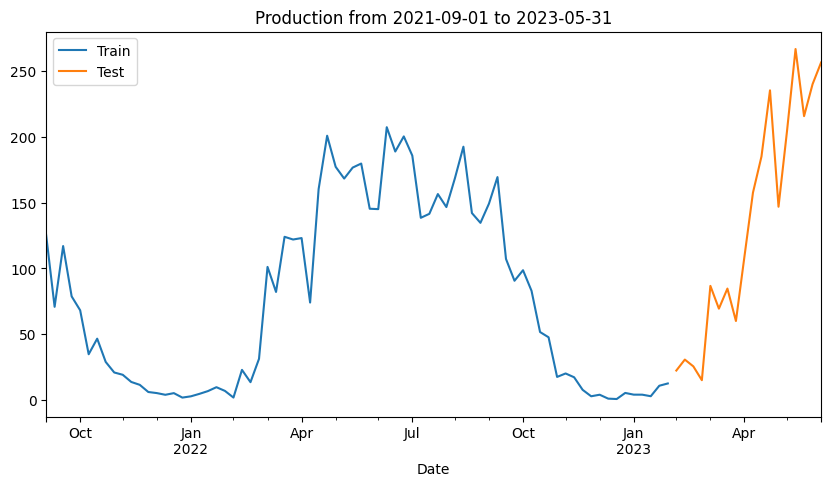

In [25]:
train_data, test_data = ts_split(production_df,test_pct=0.2,freq='W')
pts_to_pred = len(test_data)
title = 'Production from {} to {}'.format(str(production_df.index[0]).split()[0], str(production_df.index[-1]).split()[0])

pretraining_plot(train_data,test_data,"target",title)

In [26]:
train_funcs = [ets_models,arima_models,ltsf_models]

best_model = None
min_error = np.inf
for func in train_funcs:
    cur_model = BestModelWrapper(func(train_data,test_data,"target",len(test_data)))
    cur_error = get_error(test_data["target"],cur_model.forecast(pts_to_pred))
    if cur_error < min_error:
        best_model = cur_model
        min_error = cur_error



/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/atharvamhaskar/miniconda3/envs/deep-learning/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountere


    Mean Squared Error: 62.387
    Mean Absolute Error: 47.348
    Mean Absolute Percentage Error: 0.536
    Weighted Mean Squared Error: 7740.865
    Mean Forecast Error: 19.545
    


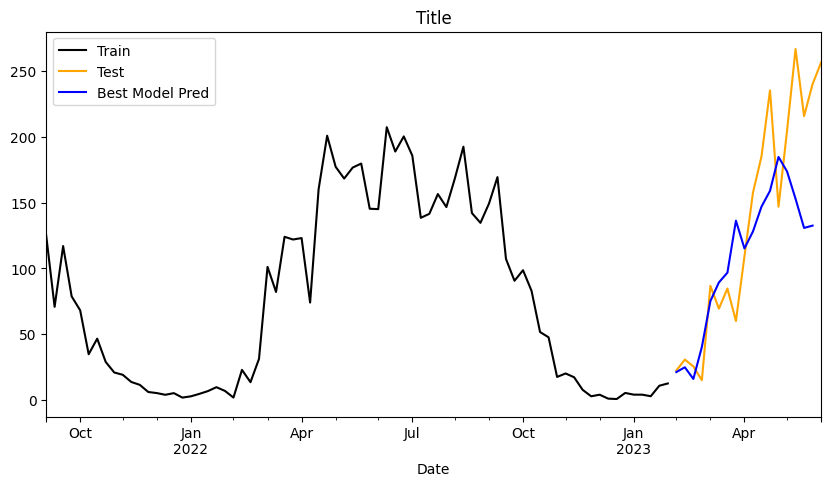

In [27]:
posttraining_plot(train_data,test_data,"target",best_model)

"<class 'sktime.forecasting.ltsf.LTSFNLinearForecaster'>"